In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import itertools
import random
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader


In [3]:
def hparameters_dict(N_EPOCHS=500,N_SAMPLES=10000,BATCH_SIZE=100,lr=1e-4):
    hp = { "N_EPOCHS":N_EPOCHS, 
            "N_SAMPLES":N_SAMPLES,
            "BATCH_SIZE":BATCH_SIZE,
            "lr":lr,
        }
    return hp

In [5]:
def train(encoder,decoder,q,x_data,opt,**kwargs):
    for x_ in x_data:
        rate = q(encoder,x_)
        distortion = distortion_analytical_linear(x_,encoder,decoder,q.r_all)
    return

In [101]:
#Architecture parameters and distributions of stimuli
N = 10
K = 5
M = 100
w = torch.distributions.Categorical(torch.tensor([0.5,0.5]))
gs = torch.distributions.normal.Normal(torch.Tensor([0,0]),torch.tensor([1,3]))
p_x = torch.distributions.mixture_same_family.MixtureSameFamily(w,gs)
p_x = torch.distributions.log_normal.LogNormal(0.5,0.8)
#Training parameters.
#PRE_EPOCHS = 100
N_EPOCHS = 500
N_SAMPLES = 5000
lr = 1e-4
BATCH_SIZE = 50
#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_test = p_x.sample((N_SAMPLES,))[:,None]
x_tsorted,_ = x_test.sort(dim=0)
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
#axs2 = axs.twinx()


Text(0, 0.5, 'Encoding')

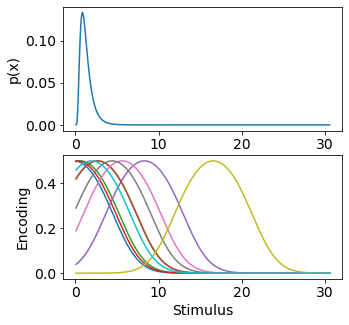

In [238]:
#Initialize model parameters
enc = BernoulliEncoder(N,x_min-1,x_max+1,x_sorted)
with torch.no_grad():
    enc.cs += np.sqrt(0.2)*torch.randn(N)
cs_sorted,indices = enc.cs.sort(dim=1)
indices = torch.squeeze(indices)
deltac = torch.diff(cs_sorted)
deltac = torch.cat((deltac[0,:],deltac[:,-1]))
#enc.cs = torch.nn.Parameter(torch.Tensor(np.linspace(x_min,x_max,num=N))[None,:])
#enc.As = torch.nn.Parameter(5*torch.ones(N)[None,:])
#enc.log_sigmas = torch.nn.Parameter(torch.log(2*deltac)[None,torch.sort(indices)[1]])
q = rate_ising(N)
#q = rate_vampBernoulli(K,x_fine)
#x_k = x_fine[random.sample(range(1000),K)]
#q.x_k = torch.nn.Parameter(x_k)
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
dec = MLPDecoder2n(N,M)
fig,axs = plt.subplots(2,1,figsize=(5,5))
axs[0].plot(x_fine,10**p_x.log_prob(x_fine).detach())
axs[0].set_xlabel("Stimulus")
axs[0].set_ylabel("p(x)")
#enc.As = torch.nn.Parameter(torch.ones(N)[None,:])
axs[1].plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
axs[1].set_xlabel("Stimulus")
axs[1].set_ylabel("Encoding")

In [239]:
params =   list(enc.parameters()) + list(dec.parameters())  + list(q.parameters())
#params = q.parameters()
#lr = 1e-4
lVec,dVec,rVec,bVec = ([] for _ in range(4))
opt = torch.optim.Adam(params,lr)
#Scheduled Beta
bVec = [1*i/N_EPOCHS  if 1*i/N_EPOCHS<1 else 1 for i in range(N_EPOCHS)]
#bVec = [1/(1 + np.exp(-x/30 + 7)) for x in range(N_EPOCHS)]
for e in range(N_EPOCHS):
    lav = dav = rav = 0
    beta = bVec[e]
    #beta=1
    for x_ in x_data:
        rate = q(enc,x_)
        #distortion = distortion_gaussian(x_,enc,dec,lat_samp = 50,tau=0.01)
        distortion = distortion_analytical_linear(x_,enc,dec,q.r_all)
        #print(enc.log_sigmas.grad)
        loss =  distortion +beta*rate
        opt.zero_grad()
        loss.backward()
        opt.step()
        lav += distortion + rate
        dav += distortion
        rav += rate
    lVec.append(lav.item()/len(x_data))
    rVec.append(rav.item()/len(x_data))
    dVec.append(dav.item()/len(x_data))
    p = torch.sigmoid(enc(x_samples))
    H = - p*torch.log(p) - (1-p)*torch.log(1-p)
    #bVec.append(beta)
    print(f"Epoch: {e} || ELBO: {lVec[-1]}|| Entropy: {H.mean()}")


Epoch: 0 || ELBO: 5.2340869140625|| Entropy: 0.5659196972846985
Epoch: 1 || ELBO: 4.504266662597656|| Entropy: 0.5677164196968079
Epoch: 2 || ELBO: 4.02058837890625|| Entropy: 0.5691001415252686
Epoch: 3 || ELBO: 3.660702819824219|| Entropy: 0.5701060891151428
Epoch: 4 || ELBO: 3.3699581909179686|| Entropy: 0.5707992911338806
Epoch: 5 || ELBO: 3.13266845703125|| Entropy: 0.5712025761604309
Epoch: 6 || ELBO: 2.9426080322265626|| Entropy: 0.5713150501251221
Epoch: 7 || ELBO: 2.7896185302734375|| Entropy: 0.5711457133293152
Epoch: 8 || ELBO: 2.6637982177734374|| Entropy: 0.5707160234451294
Epoch: 9 || ELBO: 2.560122375488281|| Entropy: 0.5700517892837524
Epoch: 10 || ELBO: 2.475506591796875|| Entropy: 0.5691856741905212
Epoch: 11 || ELBO: 2.4068734741210935|| Entropy: 0.5681535005569458
Epoch: 12 || ELBO: 2.3510455322265624|| Entropy: 0.5669882297515869
Epoch: 13 || ELBO: 2.3053688049316405|| Entropy: 0.5657153725624084
Epoch: 14 || ELBO: 2.267558898925781|| Entropy: 0.5643554329872131
Ep

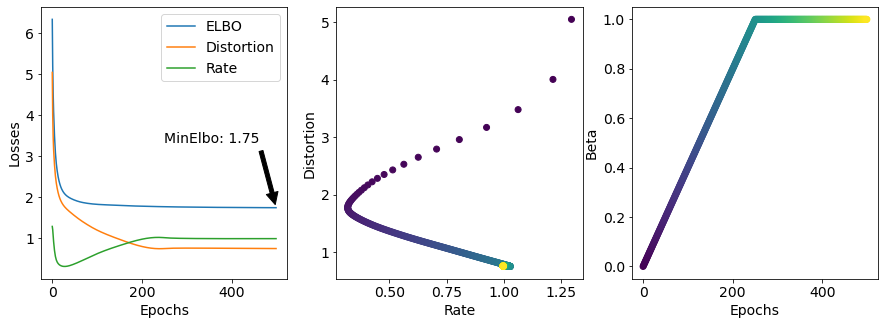

In [233]:
fig,ax = training_plots(lVec,dVec,rVec,bVec)
#fig.savefig("beta1_training.pdf")

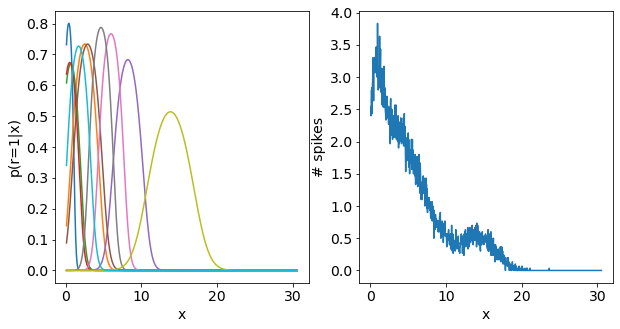

In [234]:
fig,axs = encoder_plots(enc,x_fine)
#fig.savefig("beta1_encoder.pdf")

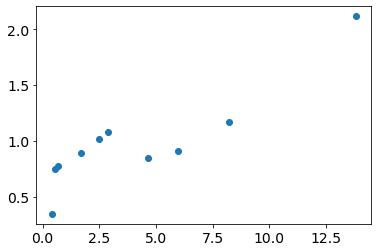

In [235]:
with torch.no_grad():
    plt.scatter(enc.cs, torch.exp(enc.log_sigmas))

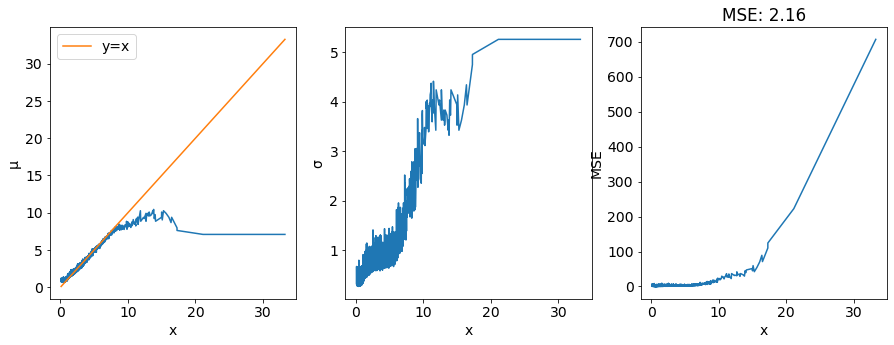

In [236]:
fig,axs = decoder_plots(enc,dec,x_tsorted)
#fig.savefig("beta1_decoder.pdf")

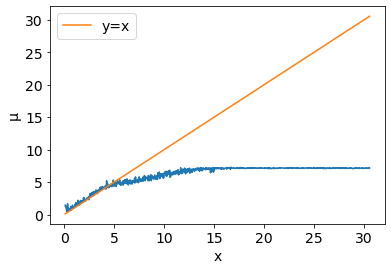

In [230]:
with torch.no_grad():
    r = enc.sample(x_fine,15)
    mu_dec,log_sigma_dec = dec(r)
    mu_dec = torch.where((r.sum(dim=2)) >0,mu_dec.double(),float('nan'))
    x_ext = dec.sample(r,10)
    mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
    fig,axs = plt.subplots()
    axs.plot(x_fine,mu_dec.nanmean(dim=1))
    axs.plot(x_fine,x_fine,label="y=x")
    axs.legend()
    axs.set_xlabel('x')
    axs.set_ylabel('μ')


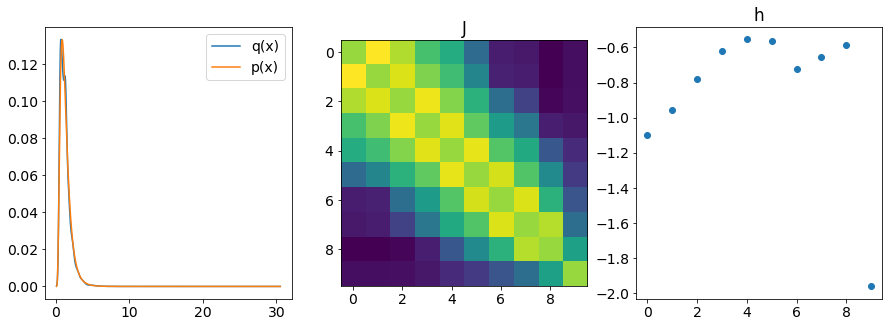

In [240]:
_,indices = enc.cs.sort(dim=1)
indices = torch.squeeze(indices)
fig,axs = generative_model_analytical_plots(q,dec,p_x,x_fine,indices)
#fig.savefig("beta1_gm.pdf")

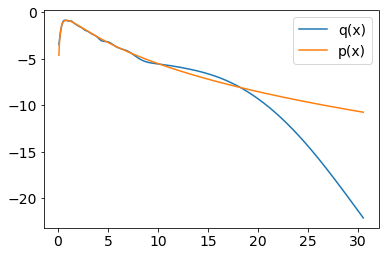

In [241]:
with torch.no_grad():
    mu_dec_all,log_sigma_all = dec(q.r_all.transpose(0,1)[:,None,:])
    q_r = torch.softmax(q.h@q.r_all + (q.r_all*(q.J@q.r_all)).sum(dim=0),1)
    wq = torch.distributions.Categorical(q_r)
    gsq = torch.distributions.normal.Normal(mu_dec_all,torch.exp(log_sigma_all))
    q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
    fig,axs = plt.subplots()
    axs.plot(x_fine,q_x.log_prob(x_fine),label= "q(x)")
    axs.plot(x_fine,p_x.log_prob(x_fine),label= "p(x)")
    axs.legend()

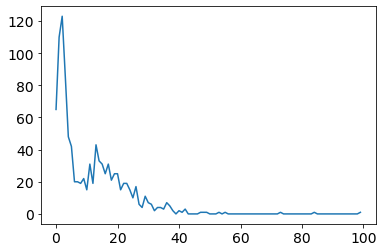

In [221]:
plt.plot(torch.histc(torch.exp(log_sigma_all)))

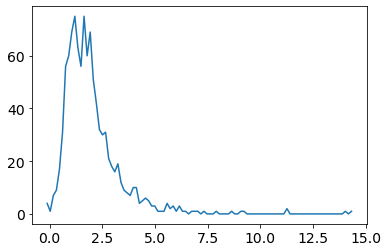

In [222]:
h = torch.histogram(mu_dec_all)
plt.plot(h.bin_edges[:-1].detach(),h.hist)

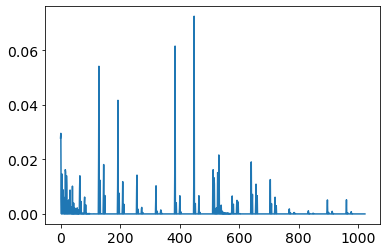

In [114]:
plt.plot(q_r.detach()[0,:])

In [115]:
-(q_r*torch.log(q_r+1E-9)).sum()

tensor(4.2830)

In [116]:
-(q_r*torch.log(q_r+1E-9)).sum()

tensor(4.2830)

In [180]:
cs_sorted,indices = enc.cs.sort(dim=1)
indices = torch.squeeze(indices)
deltac = torch.diff(cs_sorted)
deltac = torch.cat((deltac[0,:],deltac[:,-1]))
torch.nn.Parameter(torch.log(deltac)[None,indices])

Parameter containing:
tensor([[-0.5493, -0.9474, -0.8641,  1.8874, -0.9859, -0.0191,  1.1851,  0.5883,
         -0.2501,  1.8874]], requires_grad=True)

In [198]:
cs_sorted

tensor([[ 0.4735,  0.8950,  1.2681,  1.6558,  2.2332,  3.0119,  3.9931,  5.7940,
          9.0650, 15.6672]], grad_fn=<SortBackward0>)

In [182]:
deltac[None,indices]

tensor([[0.5774, 0.3877, 0.4214, 6.6023, 0.3731, 0.9811, 3.2710, 1.8009, 0.7787,
         6.6023]], grad_fn=<IndexBackward0>)

In [204]:
cs_sorted[:,torch.sort(indices)[1]]

tensor([[ 1.2681,  2.2332,  0.8950,  0.4735,  9.0650,  3.0119,  5.7940,  3.9931,
         15.6672,  1.6558]], grad_fn=<IndexBackward0>)

In [205]:
enc.cs

Parameter containing:
tensor([[ 1.2681,  2.2332,  0.8950,  0.4735,  9.0650,  3.0119,  5.7940,  3.9931,
         15.6672,  1.6558]], requires_grad=True)